In [1]:
import sys
sys.path.append("../")

In [2]:
import os

import numpy as np
import pandas as pd
import shap
import xgboost
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


## Config

In [3]:
dataset_path = os.path.abspath("../data/boston_house_price.csv")

## Load Dataset
### Description
The Boston Housing Dataset

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - \% lower status of the population
- MEDV - Median value of owner-occupied homes in \$1000's

### Reference
https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset

In [4]:
data = pd.read_csv(dataset_path)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
data.shape

(506, 14)

## Explore Data Analysis

In [6]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

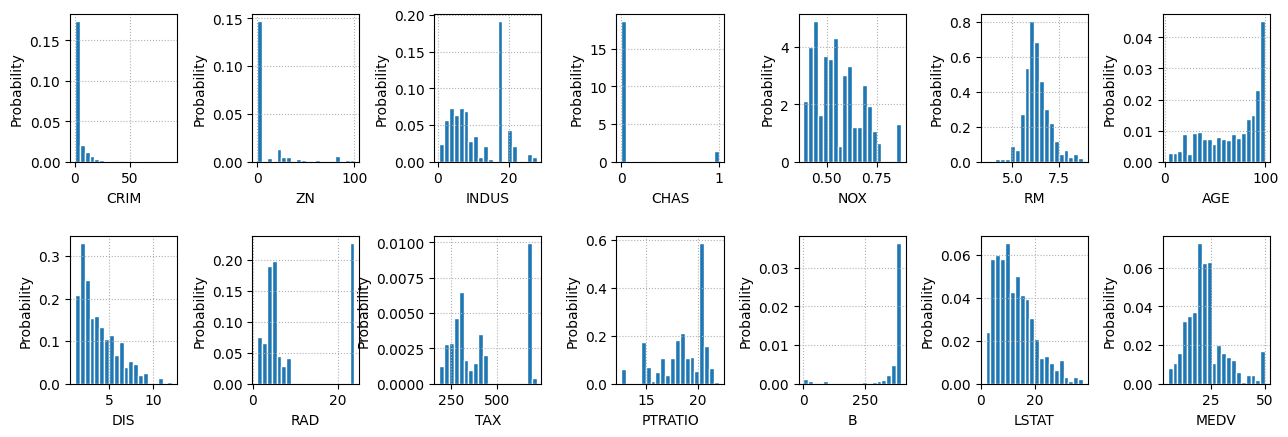

In [8]:
"""
Historgram for each feature
"""

fig, axes = plt.subplots(2, 7)
cols = data.columns
for i, col in enumerate(cols):
    rn, cn = divmod(i, 7)
    ax = axes[rn, cn]
    ax.hist(data[col], bins=20, edgecolor="white", density=True)
    ax.grid(linestyle=":")
    ax.set_xlabel(col)
    ax.set_ylabel("Probability")

fig.subplots_adjust(right=2, wspace=0.7, hspace=0.5)

In [9]:
"""
Correlation between features
"""

corr_mat = data.corr()
corr_mat.style.background_gradient(cmap="RdBu_r", vmin=-1, vmax=1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


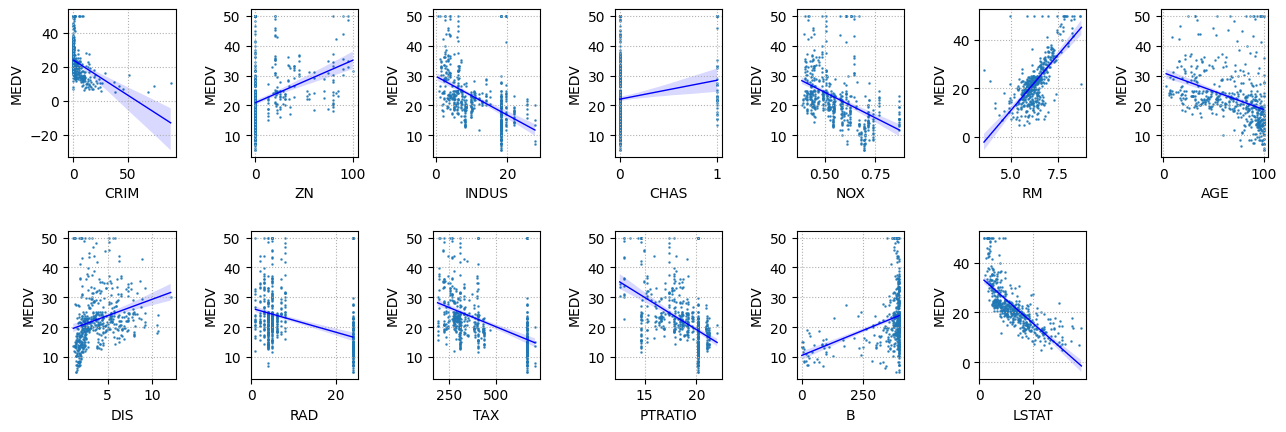

In [10]:
"""
Scatter plot for each feature vs target(=MEDV)
"""

fig, axes = plt.subplots(2, 7)
cols = data.columns
for i, col in enumerate(cols[:-1]):
    rn, cn = divmod(i, 7)
    ax = axes[rn, cn]
    ax = sns.regplot(data=data, x=col, y="MEDV", ax=ax, scatter_kws={"s": 0.7}, line_kws={"color": "blue", "linewidth": 1})
    ax.grid(linestyle=":")
    ax.set_xlabel(col)
    ax.set_ylabel("MEDV")

axes[-1, -1].axis("off")

fig.subplots_adjust(right=2, wspace=0.7, hspace=0.5)

## Preprocess Dataset

In [11]:
feature_cols = data.columns[:-1].tolist()
y_col = data.columns[-1]

print(feature_cols)
print(y_col)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
MEDV


In [12]:
X_raw = data.iloc[:, :-1].values
y_raw = data.iloc[:, -1].values

In [13]:
X_raw.shape

(506, 13)

In [14]:
y_raw.shape

(506,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (404, 13)
y_train: (404,)
X_test: (102, 13)
y_test: (102,)


## Train Model

In [16]:
model = xgboost.XGBRegressor(objective="reg:linear")
model.fit(X_train, y_train)

[13:44:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

print(f"RMSE Train: {mse_train**(1/2.):.2f}")
print(f"RMSE Test: {mse_test**(1/2.):.2f}")

RMSE Train: 0.02
RMSE Test: 2.63


## Model Interpretation

In [18]:
shap.initjs()

### Single Prediction

In [19]:
explainer = shap.TreeExplainer(model, feature_names=feature_cols)
shap_values = explainer(X_train)

In [20]:
"""
`force_plot` visualizes the given SHAP values with an additive force layout

Description:
- Base Value: 22.8
    - average model output over the training dataset
    - equivalent to `model.predict(X_train).mean()`
- Prediction: 11.99
    - model output for the given instance
    - equivalent to `model.predict([X_train[idx]])` (= `base_value + shap_values.values[idx].sum()`)
- Contribution of each feature    
    - features marked in red colored text have positive effect on the model output
    - features marked in blue colored text have negative effect on the model output
    - {Feature} = {Feature_value}
"""

idx = 0

shap.force_plot(
    explainer.expected_value,
    shap_values=shap_values.values[idx, :],
    features=X_train[idx, :],
    feature_names=feature_cols
)

In [21]:
base_value = model.predict(X_train).mean()
print(f"Base: {base_value}")

Base: 22.79652214050293


In [22]:
pred_value = model.predict([X_train[idx]])[0]
print(f"Model Prediction: {pred_value}")
print(f"Base + SHAP: {base_value + shap_values.values[idx].sum()}")

Model Prediction: 11.990928649902344
Base + SHAP: 11.990928649902344


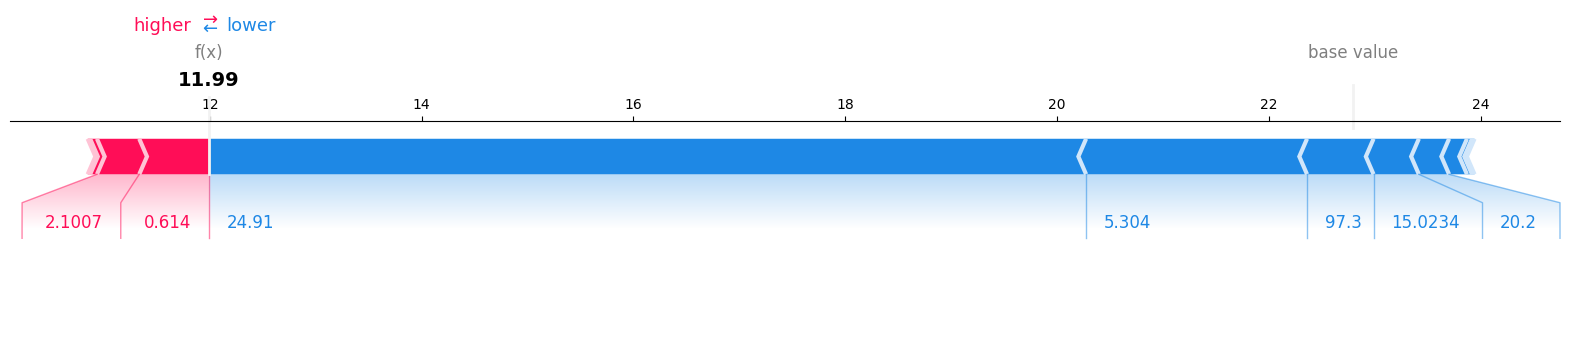

In [23]:
"""
Also can be displayed with matplotlib
"""

shap.force_plot(
    explainer.expected_value,
    shap_values=shap_values.values[idx, :],
    feature_names=X_train[idx, :],
    matplotlib=True,
)

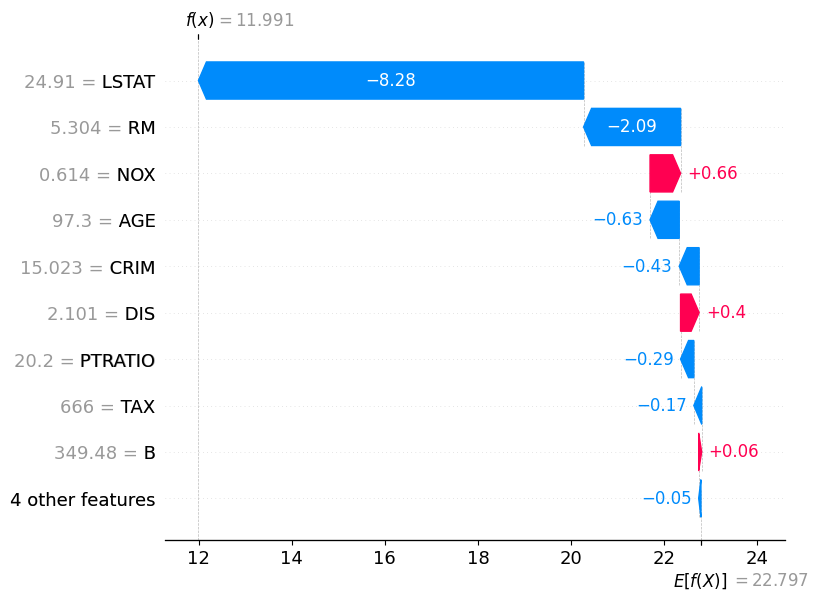

In [24]:
"""
`waterfall` displays explanation of a single prediction as a waterfall plot
(another way of visualizing shap.force_plot of a singple prediction)

show: bool
    Whether ``matplotlib.pyplot.show()`` is called before returning.
    Setting this to ``False`` allows the plot to be customized further after it has been created,
    returning the current axis via plt.gca().
"""

shap.plots.waterfall(shap_values[idx], show=True)

### Overall Prediction

In [25]:
"""
`force_plot` also can display the explanations for entire dataset
(rotate individual prediction results 90 degrees, and then stack them horizontally)

x-axis: sample number (index)
y-axis: SHAP value
"""

shap.force_plot(
    explainer.expected_value,
    shap_values=shap_values.values,
    features=X_train,
    feature_names=feature_cols,
)

#### Output Example
- `force_plot` for entire dataset cannot be displayed with matplotlib
![title](../figures/shap_force_plot_example.png)

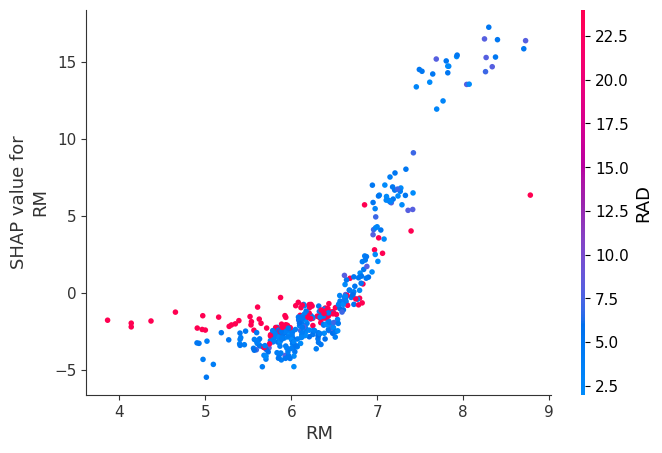

In [26]:
"""
`dependence_plot` displays how the model depends on the given feature,
and is like a richer extension of the classical partial dependence plots

x-axis: feature value
y-axis (left): SHAP value
y-axis (right): display the feature which has the greatest interaction effect with RM (RAD in this case)
color: feature value of the right y-axis (higher: red, lower: blue)

interpretation
- when RAD has a relatively large value (red dots), SHAP value for RM does not change much (ranges from -5 ~ 5)
- when RAD has a relatively small value (blue dots), SHAP value for RM changes much (ranges from -5 ~ 15)
"""

shap.dependence_plot(
    ind="RM",
    shap_values=shap_values.values,
    features=X_train,
    feature_names=feature_cols,
)

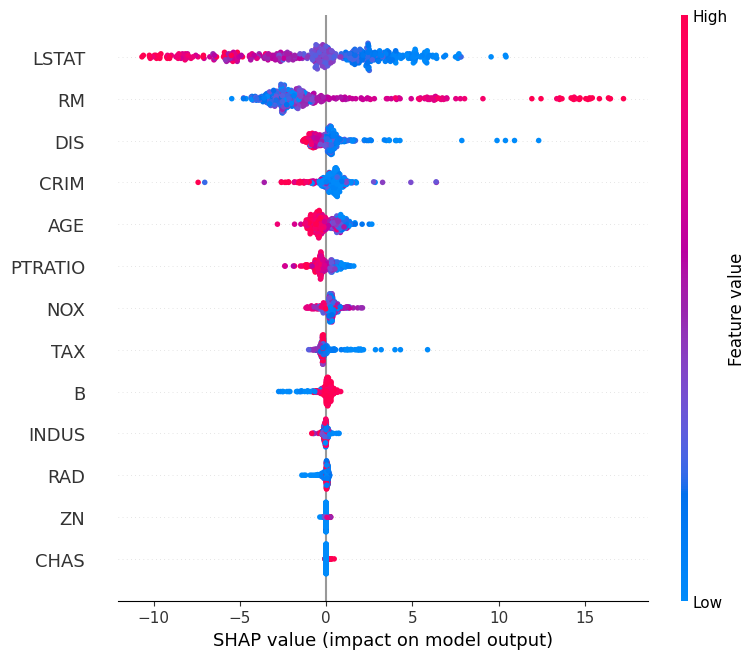

In [27]:
"""
`summary_plot` displays an overview of which features are most important for a model

x-axis: SHAP value (impact on model output)
y-axis: feature name
color: feature value (higher: red, lower: blue)

interpretation example
- larger values of LSTAT tend to have smaller SHAP values (red colored dots are located in the left side of SHAP value)
- larger values of RM tend to have larger SHAP values (red colored dots are located in the right side of SHAP value)
"""

shap.summary_plot(
    shap_values.values,
    features=X_train,
    feature_names=feature_cols,
)

In [28]:
# x = shap_values.data[:, -1]
# y = shap_values.values[:, -1]

# fig, ax = plt.subplots(1,1)
# ax.scatter(x,y, s=5)
# plt.show()

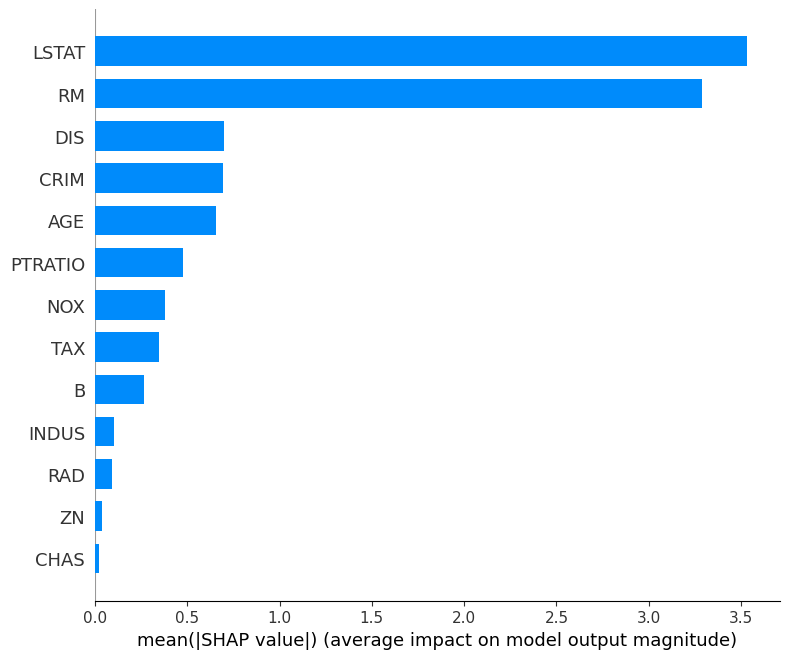

In [29]:
"""
`summary_plot` displays the average impact of each feature on model output (=average of absolute values of SHAP value)
"""

shap.summary_plot(
    shap_values.values,
    features=X_train,
    feature_names=feature_cols,
    plot_type="bar"
)

In [30]:
"""
equivalent to the plot above
"""

pd.Series(np.abs(shap_values.values).mean(axis=0), index=feature_cols).sort_values(ascending=False)

LSTAT      3.534237
RM         3.289844
DIS        0.700433
CRIM       0.692894
AGE        0.652970
PTRATIO    0.477910
NOX        0.377052
TAX        0.344319
B          0.267837
INDUS      0.100535
RAD        0.093834
ZN         0.035533
CHAS       0.019941
dtype: float32